In [1]:
import os
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pandas.plotting import register_matplotlib_converters
pd.options.mode.chained_assignment = None
register_matplotlib_converters()

In [2]:
#data collection
df = pd.read_csv('../input/btcusd/BTC-USD.csv')

In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1513,2021-12-31,47169.371094,48472.527344,45819.953125,46306.445313,46306.445313,36974172400
1514,2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004
1515,2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,47345.218750,27951569547
1516,2022-01-03,47343.542969,47510.726563,45835.964844,46458.117188,46458.117188,33071628362
1517,2022-01-04,46505.226563,46722.738281,46063.093750,46545.582031,46545.582031,33679466496


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000,1.518000e+03
mean,18215.372560,18712.187936,17666.803321,18238.019063,18238.019063,2.520603e+10
std,17531.410566,18013.538524,16976.481187,17538.456313,17538.456313,2.099220e+10
min,3236.274658,3275.377930,3191.303467,3236.761719,3236.761719,2.923670e+09
25%,7187.550171,7324.363403,6948.230102,7189.858277,7189.858277,7.736592e+09
50%,9523.907226,9700.821778,9316.446289,9525.557129,9525.557129,2.124644e+10
75%,23213.368652,23965.843262,22690.849609,23418.307617,23418.307617,3.578419e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


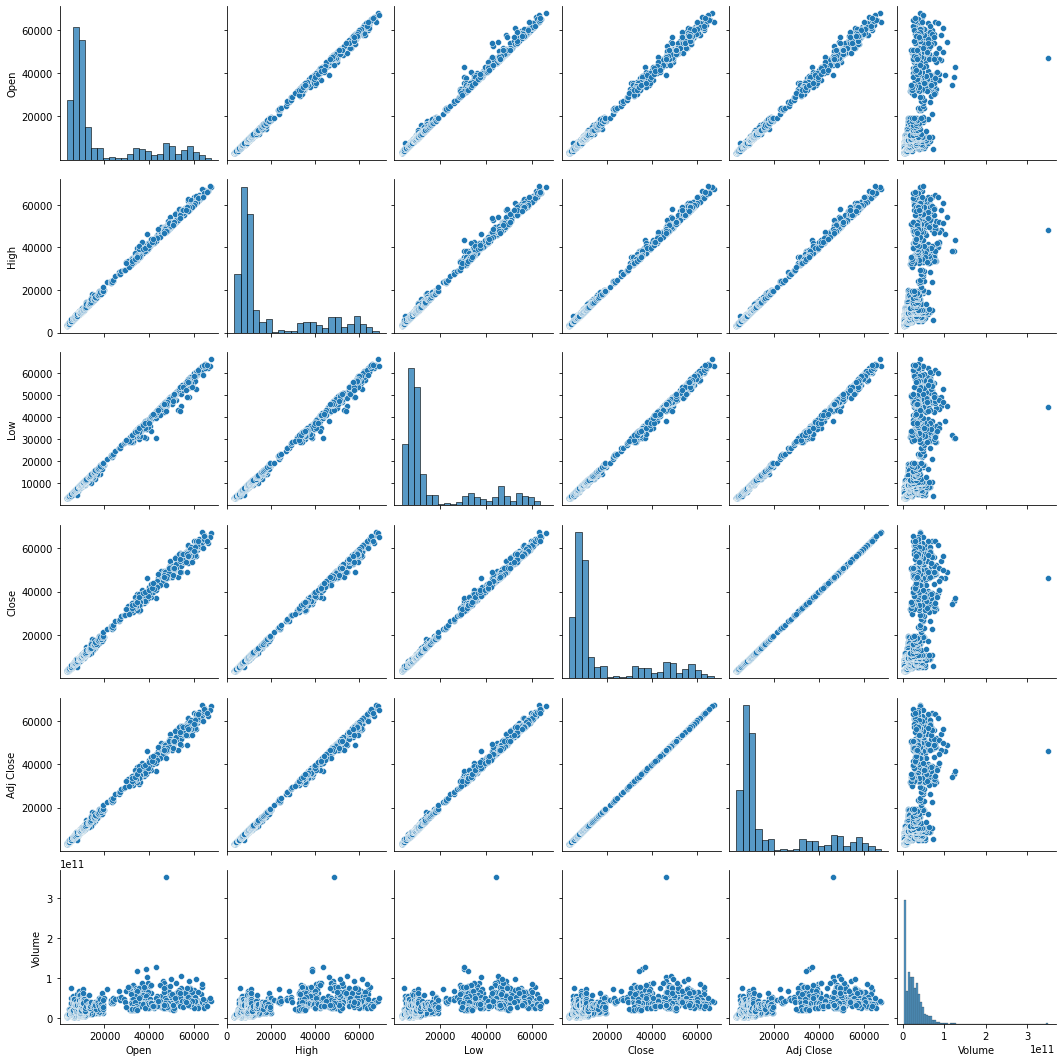

In [5]:
sns.pairplot(df)

<AxesSubplot:>

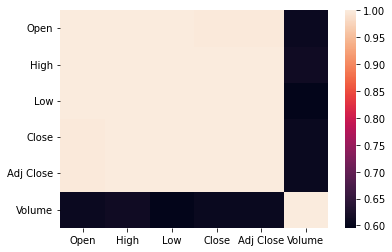

In [6]:
corr = df.corr()
sns.heatmap(corr)

In [7]:
df1 = df.reset_index()['Close']

In [8]:
df1

0        7143.580078
1        6618.140137
2        6357.600098
3        5950.069824
4        6559.490234
            ...     
1513    46306.445313
1514    47686.812500
1515    47345.218750
1516    46458.117188
1517    46545.582031
Name: Close, Length: 1518, dtype: float64

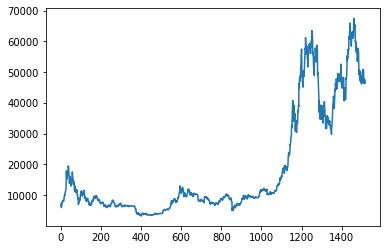

In [9]:
plt.plot(df1)

In [10]:
#LSTM are sensitive to the scale of the data,so we apply MinMax scaler
scaler = MinMaxScaler(feature_range =(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))


In [11]:
print(df1)

[[0.06073083]
 [0.05256296]
 [0.0485129 ]
 ...
 [0.6856585 ]
 [0.67186866]
 [0.67322829]]


In [12]:
#splitting dataset into train and test split
training_size = int(len(df1)*0.65)
test_size = len(df1)- training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [13]:
training_size,test_size

(986, 532)

In [14]:
#convert an array of values into dataset matrix
def create_dataset(dataset,time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step , 0])
    return np.array(dataX), np.array(dataY)

In [15]:
#reshape into X=t, t+1, t+2, t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data,time_step) 

In [16]:
print(X_train)

[[0.06073083 0.05256296 0.0485129  ... 0.0972775  0.10772006 0.10876934]
 [0.05256296 0.0485129  0.04217792 ... 0.10772006 0.10876934 0.12243013]
 [0.0485129  0.04217792 0.05165125 ... 0.10876934 0.12243013 0.11371103]
 ...
 [0.06319483 0.05640802 0.05630837 ... 0.09258618 0.09164402 0.09194194]
 [0.05640802 0.05630837 0.05804953 ... 0.09164402 0.09194194 0.09206081]
 [0.05630837 0.05804953 0.05609004 ... 0.09194194 0.09206081 0.09247706]]


In [17]:
print(X_train.shape),print(y_train.shape)

(885, 100)
(885,)


(None, None)

In [18]:
 print(X_test.shape), print(y_test.shape)

(431, 100)
(431,)


(None, None)

In [19]:
#reshape inputs to be[samples,time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [20]:
#Create the LSTM model
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer = 'adam')

2022-01-06 11:57:21.382788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-06 11:57:21.466864: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-06 11:57:21.467638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-06 11:57:21.468931: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


2022-01-06 11:57:24.377623: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-06 11:57:28.391127: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


14/14 [==============================] - 7s 105ms/step - loss: 0.0015 - val_loss: 0.2139
Epoch 2/100
14/14 [==============================] - 0s 20ms/step - loss: 5.9804e-04 - val_loss: 0.0977
Epoch 3/100
14/14 [==============================] - 0s 19ms/step - loss: 2.7164e-04 - val_loss: 0.0143
Epoch 4/100
14/14 [==============================] - 0s 19ms/step - loss: 2.0769e-04 - val_loss: 0.0267
Epoch 5/100
14/14 [==============================] - 0s 19ms/step - loss: 1.8694e-04 - val_loss: 0.0189
Epoch 6/100
14/14 [==============================] - 0s 19ms/step - loss: 1.7026e-04 - val_loss: 0.0213
Epoch 7/100
14/14 [==============================] - 0s 19ms/step - loss: 1.5779e-04 - val_loss: 0.0188
Epoch 8/100
14/14 [==============================] - 0s 19ms/step - loss: 1.4595e-04 - val_loss: 0.0196
Epoch 9/100
14/14 [==============================] - 0s 20ms/step - loss: 1.3621e-04 - val_loss: 0.0219
Epoch 10/100
14/14 [==============================] - 0s 20ms/step - loss: 1.40

In [23]:
#Lets do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [24]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [25]:
#calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

7860.1170989793245

In [26]:
#test data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

34821.32628479651

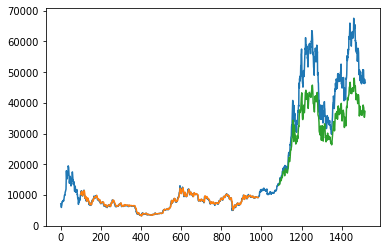

In [27]:
#plotting
#shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
#shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] =np.nan 
testPredictPlot[len(train_predict)+(look_back*2) + 1:len(df1)-1,:]= test_predict
#plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [28]:
len(test_data)

532

In [29]:
x_input = test_data[432:].reshape(1,-1)
x_input.shape

(1, 100)

In [30]:
temp_input = list(x_input)
temp_input =temp_input[0].tolist()

In [31]:
#demonstrate prediction for next 10 days
from numpy import array

lst_output =[]
n_steps = 100
i = 0
while(i<30):
  if(len(temp_input)>100):
    #print(temp_input)
    x_input = np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape((1,n_steps,1))
    #print(x_input)
    yhat = model.predict(x_input,verbose= 0)
    print("{} day input {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    #print(temp_input)
    lst_output.extend(yhat.tolist())
    i = i+1
  else:
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input,verbose= 0) 
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i = i+1
print(lst_output)

    

[0.51612633]
101
1 day input [0.58756012 0.59579608 0.63040713 0.6976548  0.6913521  0.6989452
 0.71313685 0.75047413 0.81026945 0.78609001 0.78860615 0.80415681
 0.8011     0.84327641 0.82083386 0.84197544 0.84073847 0.90715261
 0.89624372 0.90652565 0.91386998 0.94862688 0.97553256 0.91673168
 0.89313609 0.90403848 0.89684462 0.92962849 0.88803004 0.8587839
 0.89204595 0.91700827 0.91173651 0.9028779  0.89798826 0.93252882
 0.92854381 0.90494961 0.89987338 0.90611936 0.93409241 1.
 0.99075083 0.96002495 0.95932124 0.94697834 0.95185298 0.96735604
 0.93768144 0.88488148 0.88809562 0.83484097 0.8531441  0.87766789
 0.86264041 0.82469256 0.84458661 0.82455478 0.84001029 0.78241803
 0.8017762  0.83960267 0.84827838 0.83582479 0.83931308 0.82762319
 0.78286076 0.71450169 0.71711547 0.73598344 0.73780935 0.73477361
 0.69074014 0.68407427 0.71701692 0.72845524 0.67621131 0.67427058
 0.70977637 0.69063607 0.66788961 0.67794141 0.67573774 0.67843107
 0.71039646 0.70560708 0.73912216 0.7397075

In [32]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [33]:
len(df1)

1518

In [34]:
df3 = df1.tolist()
df3.extend(lst_output)

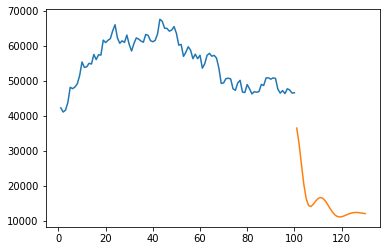

In [35]:
plt.plot(day_new,scaler.inverse_transform(df1[1418:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

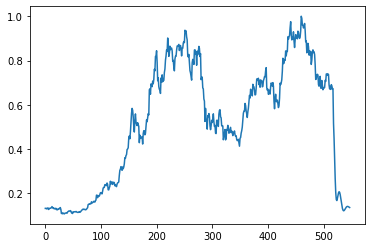

In [36]:
plt.plot(df3[1000:])

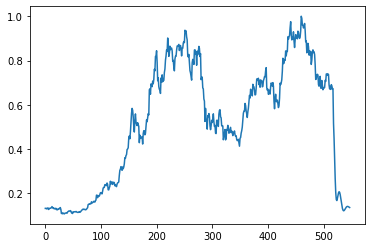

In [37]:
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1000:])